In [1]:
# import all the tools we need
import urllib
import pandas as pd
import numpy as np
import cv2
import itertools
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Dataset
import os 
from PIL import Image
import random
import xml.etree.ElementTree as ET
import time
import requests

In [2]:
import pandas as pd
df = pd.read_csv (r'/home/jupyter/mammo_custom/mammo_custom.csv')
print('Data tatal:',len(df))

Train = df[df['Split']!='test']
# Train = Train[Train['Split']!='test']
Test = df[df['Split']=='test']
print('Data train:',len(Train))
print('Data test:',len(Test))
Train.head()

Data tatal: 210
Data train: 182
Data test: 28


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,img_path,tagName,originalImage,left,top,width,height,Rleft,Rtop,Rwidth,Rheight,fileName,Split
0,0,0,0,/home/jupyter/mammo_custom/train/Internal/mamm...,mammo,https://irisprodseatraining.blob.core.windows....,144,346,31,26,0.203652,0.486986,0.044944,0.037921,mammo_0.jpg,train
1,1,1,1,/home/jupyter/mammo_custom/train/Internal/mamm...,mammo,https://irisprodseatraining.blob.core.windows....,150,279,25,25,0.212079,0.392885,0.035112,0.036517,mammo_1.jpg,train
2,2,2,2,/home/jupyter/mammo_custom/train/Internal/mamm...,mammo,https://irisprodseatraining.blob.core.windows....,100,444,34,31,0.141854,0.624627,0.049157,0.043539,mammo_2.jpg,train
3,3,3,3,/home/jupyter/mammo_custom/train/Internal/mamm...,mammo,https://irisprodseatraining.blob.core.windows....,75,297,25,28,0.106592,0.417580,0.036466,0.040673,mammo_3.jpg,train
4,4,4,4,/home/jupyter/mammo_custom/train/Internal/mamm...,mammo,https://irisprodseatraining.blob.core.windows....,226,295,31,34,0.317416,0.415357,0.043539,0.049157,mammo_4.jpg,train


In [3]:
# path of images directory
dir_path = '/home/jupyter/mammo_custom/train_all'

# path of xml files directory
# csv_path = '/content/drive/MyDrive/CONEX_ConcealedGun/annotation'

# List of Image file name 
file_list = os.listdir(dir_path)

# How many image files?
print('There are total {} images.'.format(len(file_list)))

There are total 182 images.


In [4]:
def read_annot(file_name, Train):
    bbox = []
    labels = []
    for i, data in enumerate(Train['fileName']):
    # print(i)
        if Train['fileName'][i] == file_name:
            print(Train['fileName'][i])
            ymin = int(Train['left'][i])
            xmin = int(Train['top'][i])
            ymax = int(Train['width'][i])
            xmax = int(Train['height'][i])
            label = Train['tagName'][i]
            bbox.append([xmin,ymin,xmax,ymax])
            if label == 'mammo':
                label_idx = 0
            else:
                label_idx = 1
            labels.append(label_idx)
    return bbox, labels

In [5]:
# help function for drawing bounding boxes on image
def draw_boxes(img, boxes,labels, thickness=1):
    """
    Function to draw bounding boxes
    Input:
        img: array of img (h, w ,c)
        boxes: list of boxes (int)
        labels: list of labels (int)
    
    """
    # imgHeight, imgWidth, _ = img.shape
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    # for i in enumerate(score):
    for box,label in zip(boxes,labels):
        box = [int(x) for x in box]
        if label == 1:
            label1 = 'No Mammo'
            color = (0,225,0) # green
        elif label == 0:
            label1 = 'Mammo'
            color = (0,0,225) # red
        cv2.rectangle(img, (box[1],box[0]),(box[1]+box[3],box[0]+box[2]),color,thickness)
        labelSize=cv2.getTextSize(label1,cv2.FONT_HERSHEY_COMPLEX,1,3)
        # print('labelSize>>',labelSize)
        _x1 = box[1]
        _y1 = box[0]
        _x2 = _x1+labelSize[0][0]
        _y2 = _y1-int(labelSize[0][1])
        cv2.rectangle(img,(_x1,_y1),(_x2,_y2),color,cv2.FILLED)
        cv2.putText(img,label1,(box[1],box[0]),cv2.FONT_HERSHEY_COMPLEX,1,(0,0,0),2)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mammo_175.jpg
mammo_175.jpg


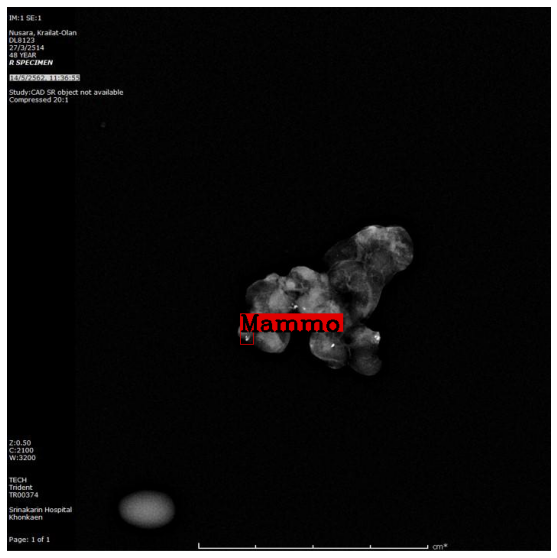

In [6]:
# file_list.sort()
# Get the image randomly
image_name = file_list[random.randint(0,len(file_list))] # random select an image
print(image_name)
# Get the bbox and label
bbox, labels  = read_annot(image_name, Train)

# #draw bounding boxes on the image
img = draw_boxes(plt.imread(os.path.join(dir_path,image_name)), bbox,labels)
    
# # display the image
fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.axis('off')
ax.imshow(img)

In [18]:
class image_dataset(Dataset):
    def __init__(self, image_list, image_dir, csv_dir):
        self.image_list = image_list
        self.image_dir = image_dir
        self.csv_dir = csv_dir
       
    def __getitem__(self, idx):
        """
        Load the image
        """
        img_name = self.image_list[idx]
        img_path = os.path.join(self.image_dir, img_name)
        img = Image.open(img_path).convert('RGB')
        img = transforms.ToTensor()(img)

        """
        build the target dict
        """
        bbox, labels = read_annot(img_name,self.csv_dir)
        boxes = torch.as_tensor(bbox, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        ls
        area = (boxes[:,2] - boxes[:,0]) * (boxes[:,3] - boxes[:,1])
        area = torch.as_tensor(area, dtype=torch.float32)
        iscrowd = torch.zeros((len(bbox),), dtype=torch.int64)
        
        target = {}
        
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])
        target['area'] = area
        target['iscrowed'] = iscrowd
        return img , target
                    
    def __len__(self):
        return len(self.image_list)

In [19]:
csv_path = Train
csv_dir = Train

In [20]:
mask_dataset = image_dataset(file_list, dir_path, csv_path)

def collate_fn(batch):
    return tuple(zip(*batch))

mask_loader = DataLoader(mask_dataset,
                        batch_size=2,
                        shuffle=True,
                        num_workers=2,
                        collate_fn=collate_fn)

In [21]:
#boxes = torch.as_tensor(boxes, dtype=torch.float32) #add by me

In [22]:
# Setting up GPU device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [23]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    model = model.to(device)
    return model

In [24]:
# Setting the optimizer, lr_scheduler, epochs
model = get_model_instance_segmentation(1)
params = [p for p in model.parameters() if p.requires_grad]
#optimizer = torch.optim.Adam(params, lr=0.01)
optimizer = torch.optim.SGD(params, lr=0.01,momentum=0.9, weight_decay=0.0005)
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)
num_epochs=2

In [27]:
# Main training function
loss_list = []

for epoch in range(num_epochs):
    print('Starting training....{}/{}'.format(epoch+1, num_epochs))
    loss_sub_list = []
    start = time.time()
    for images, targets in mask_loader:
#         print(images,targets)
        images = list(image.to(device) for image in images)
        targets = [{k:v.to(device) for k,v in t.items()} for t in targets]
        print(images,targets)
        model.train()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        loss_sub_list.append(loss_value)
      
      # update optimizer and learning rate
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
      #lr_scheduler.step()
    end = time.time()
        
    #print the loss of epoch
    epoch_loss = np.mean(loss_sub_list)
    loss_list.append(epoch_loss)
    print('Epoch loss: {:.3f} , time used: ({:.1f}s)'.format(epoch_loss, end-start))


Starting training....1/2
mammo_58.jpg
mammo_179.jpg
mammo_146.jpg
mammo_115.jpg
mammo_157.jpg
mammo_32.jpg
mammo_130.jpg
mammo_170.jpg
mammo_85.jpg
mammo_156.jpg
[tensor([[[0.4902, 0.5451, 0.5294,  ..., 0.0000, 0.0000, 0.0000],
         [0.4824, 0.5059, 0.4980,  ..., 0.0000, 0.0000, 0.0000],
         [0.4510, 0.4471, 0.4706,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.2118, 0.0667, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         [0.1255, 0.1490, 0.1373,  ..., 0.1255, 0.1255, 0.1255]],

        [[0.4902, 0.5451, 0.5294,  ..., 0.0039, 0.0039, 0.0039],
         [0.4824, 0.5059, 0.4980,  ..., 0.0039, 0.0039, 0.0039],
         [0.4510, 0.4471, 0.4706,  ..., 0.0039, 0.0039, 0.0039],
         ...,
         [0.2118, 0.0667, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         [0.1255, 0.1490, 0.1373,  ..., 0.1255, 0.1255, 0.1255]],

        [[0.4902, 0.5451,

ValueError: All bounding boxes should have positive height and width. Found invalid box [410.25, 110.125, 32.59375, 33.71875] for target at index 0.

In [ ]:
mammo_8.jpg

### Checking images

In [19]:
os.chdir('/home/jupyter/mammo_custom/train_all')

In [20]:
df = Train 
img_path = df['fileName'].tolist()
originalImage = df['originalImage'].tolist()
Left = df['left'].tolist()
Top = df['top'].tolist()
Width = df['width'].tolist()
Height = df['height'].tolist()

mammo_8.jpg


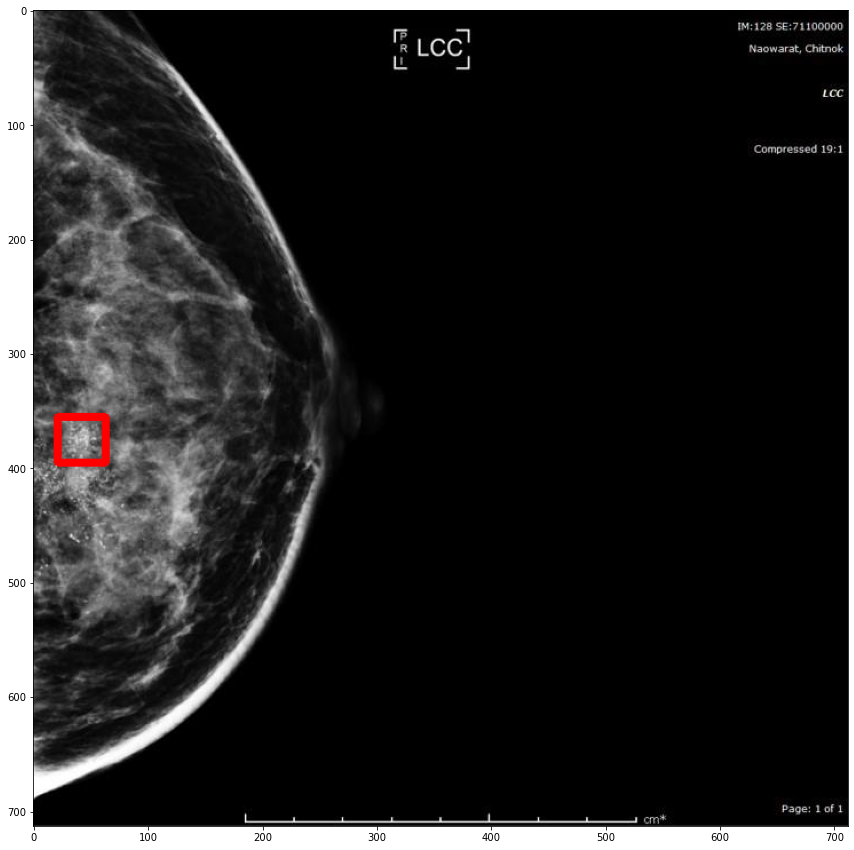

In [21]:
i = 8
origImage = originalImage[i]
imgpath = img_path[i]
left = Left[i]
top = Top[i]
width = Width[i]
height = Height[i]
from IPython.display import Image
import cv2
print(imgpath)
img_c = cv2.imread(imgpath)
img_c = cv2.rectangle(img_c, (left,top), (left+width,top+height), (255,0,0), 5)
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 15]
plt.imshow(img_c)